In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from itertools import product
from torch import tensor
import pickle
import time
from tqdm import tqdm

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
trainset, valset = torch.utils.data.random_split(trainset, [45000, 5000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [12]:
resume = True

if resume: 
    with open('sgd_big_results.pkl', 'rb') as f:
        arr = pickle.load(f)
        test_accuracy_history_sgd = arr["acc"]
        test_loss_history_sgd = arr["loss"]
        loss_in_training_sgd = arr["loss_train"]
        time_learning_sgd = arr["time"]
else:
    test_accuracy_history_sgd, test_loss_history_sgd, loss_in_training_sgd, time_learning_sgd = {}, {}, {}, {}

In [13]:
test_accuracy_history_sgd

{(0.1, 0.001): [0.5528,
  0.6504,
  0.716,
  0.772,
  0.767,
  0.7688,
  0.7628,
  0.7768,
  0.7654,
  0.7698,
  0.7932,
  0.7826,
  0.7782,
  0.7772,
  0.7916,
  0.7704,
  0.7684,
  0.785,
  0.7818,
  0.7918],
 (0.1, 0.0003): [0.564,
  0.654,
  0.699,
  0.7602,
  0.7418,
  0.755,
  0.7694,
  0.7762,
  0.7738,
  0.7676,
  0.7852,
  0.7838,
  0.7832,
  0.7982,
  0.804,
  0.8026,
  0.8058,
  0.8088,
  0.8126,
  0.805],
 (0.1, 0.0001): [0.5112,
  0.6754,
  0.7198,
  0.7356,
  0.7534,
  0.7592,
  0.7504,
  0.7662,
  0.7648,
  0.7674,
  0.7822,
  0.7862,
  0.7972,
  0.7944,
  0.8044,
  0.8064,
  0.8032,
  0.8088,
  0.8052,
  0.8066],
 (0.1, 0): [0.563,
  0.6718,
  0.7332,
  0.7532,
  0.755,
  0.7558,
  0.7634,
  0.7662,
  0.7652,
  0.7752,
  0.778,
  0.7846,
  0.7924,
  0.8024,
  0.8082,
  0.8096,
  0.8066,
  0.8094,
  0.8136,
  0.809],
 (0.03, 0.001): [0.4986,
  0.613,
  0.672,
  0.6888,
  0.6918,
  0.7098,
  0.7226,
  0.7072,
  0.7178,
  0.725,
  0.742,
  0.7446,
  0.7446,
  0.7474,
  0.7

In [7]:
for learning_rate, weight_decay in product([0.1, 0.03, 0.01], [1e-3, 3e-4, 1e-4, 0]):
    key = (learning_rate, weight_decay)
    if key in test_accuracy_history_sgd:
        print("Already computed, ignoring")
        continue
    
    lenet = torchvision.models.resnet18(pretrained=False)
    lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
    lenet.maxpool = torch.nn.Identity()
    lenet.cuda()
    loss = torch.nn.CrossEntropyLoss()
    
    optimizer = torch.optim.SGD(lenet.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    test_loss_history_sgd[key] = list()
    test_accuracy_history_sgd[key] = list()
    loss_in_training_sgd[key] = list()
    time_learning_sgd[key] = list()

    for epoch in range(20):
        
        sum_los = 0
        start_time = time.time()
        
        for i, data in enumerate(trainloader, 0):
            
            optimizer.zero_grad()

            X_batch, y_batch = data
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

            preds = lenet.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()
            sum_los += float(loss_value)
            optimizer.step()
        
        time_learning_sgd[key].append(time.time() - start_time)
        loss_in_training_sgd[key].append(sum_los/450)
        
        correct = 0
        total = 0
        los = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()
                outputs = lenet.forward(images)
                outputs = outputs.cuda()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                loss_value = loss(outputs, labels)
                total += labels.size(0)
                los += loss_value
                
        test_loss_history_sgd[key].append(los/50)
        print('los epoch', epoch, ':', los/50)
        
        test_accuracy_history_sgd[key].append(correct/total)
        print('accuracy epoch', epoch, ':', correct/total)
                
            
    print(test_accuracy_history_sgd[(learning_rate, weight_decay)])
    print(loss_in_training_sgd[(learning_rate, weight_decay)])
    with open('sgd_big_results.pkl', 'wb') as f:
        pickle.dump({"acc": test_accuracy_history_sgd, "loss": test_loss_history_sgd, "loss_train":loss_in_training_sgd, "time":time_learning_sgd}, f)

Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring


In [8]:
for learning_rate in [1.5, 2, 1, 0.8, 0.5, 0.4, 0.3, 0.2, 0.1]:
    key = 'schedule_' + str(learning_rate)
    if key in test_accuracy_history_sgd:
        print("Already computed, ignoring")
        continue
    
    lenet = torchvision.models.resnet18(pretrained=False)
    lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
    lenet.maxpool = torch.nn.Identity()
    lenet.cuda()
    loss = torch.nn.CrossEntropyLoss()
    
    optimizer = torch.optim.SGD(lenet.parameters(), lr=learning_rate, weight_decay=0.001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
    
    test_loss_history_sgd[key] = list()
    test_accuracy_history_sgd[key] = list()
    loss_in_training_sgd[key] = list()
    time_learning_sgd[key] = list()

    for epoch in range(20):
        
        sum_los = 0
        start_time = time.time()
        
        for i, data in enumerate(trainloader, 0):
            
            optimizer.zero_grad()

            X_batch, y_batch = data
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

            preds = lenet.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()
            sum_los += float(loss_value)
            optimizer.step()
        
        scheduler.step()
        time_learning_sgd[key].append(time.time() - start_time)
        loss_in_training_sgd[key].append(sum_los/450)
        
        correct = 0
        total = 0
        los = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()
                outputs = lenet.forward(images)
                outputs = outputs.cuda()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                loss_value = loss(outputs, labels)
                total += labels.size(0)
                los += loss_value
                
        test_loss_history_sgd[key].append(los/50)
        print('los epoch', epoch, ':', los/50)
        
        test_accuracy_history_sgd[key].append(correct/total)
        print('accuracy epoch', epoch, ':', correct/total)
                
            
    print(test_accuracy_history_sgd[key])
    print(loss_in_training_sgd[key])
    with open('sgd_big_results.pkl', 'wb') as f:
        pickle.dump({"acc": test_accuracy_history_sgd, "loss": test_loss_history_sgd, "loss_train":loss_in_training_sgd, "time":time_learning_sgd}, f)

los epoch 0 : tensor(1.8265, device='cuda:0')
accuracy epoch 0 : 0.34
los epoch 1 : tensor(1.6225, device='cuda:0')
accuracy epoch 1 : 0.396
los epoch 2 : tensor(1.1358, device='cuda:0')
accuracy epoch 2 : 0.6056
los epoch 3 : tensor(0.8791, device='cuda:0')
accuracy epoch 3 : 0.6992
los epoch 4 : tensor(1.0195, device='cuda:0')
accuracy epoch 4 : 0.6546
los epoch 5 : tensor(0.8412, device='cuda:0')
accuracy epoch 5 : 0.7208
los epoch 6 : tensor(0.7633, device='cuda:0')
accuracy epoch 6 : 0.7446
los epoch 7 : tensor(0.8155, device='cuda:0')
accuracy epoch 7 : 0.7306
los epoch 8 : tensor(0.6788, device='cuda:0')
accuracy epoch 8 : 0.7722
los epoch 9 : tensor(0.7036, device='cuda:0')
accuracy epoch 9 : 0.7666
los epoch 10 : tensor(0.6854, device='cuda:0')
accuracy epoch 10 : 0.7742
los epoch 11 : tensor(0.5847, device='cuda:0')
accuracy epoch 11 : 0.8062
los epoch 12 : tensor(0.5966, device='cuda:0')
accuracy epoch 12 : 0.8072
los epoch 13 : tensor(0.5876, device='cuda:0')
accuracy epoch

In [6]:
colors = ['r', 'b', 'g', 'k', 'm', 'c', 'y', 'orange', 'teal', 'cyan', 'purple', 'deeppink']

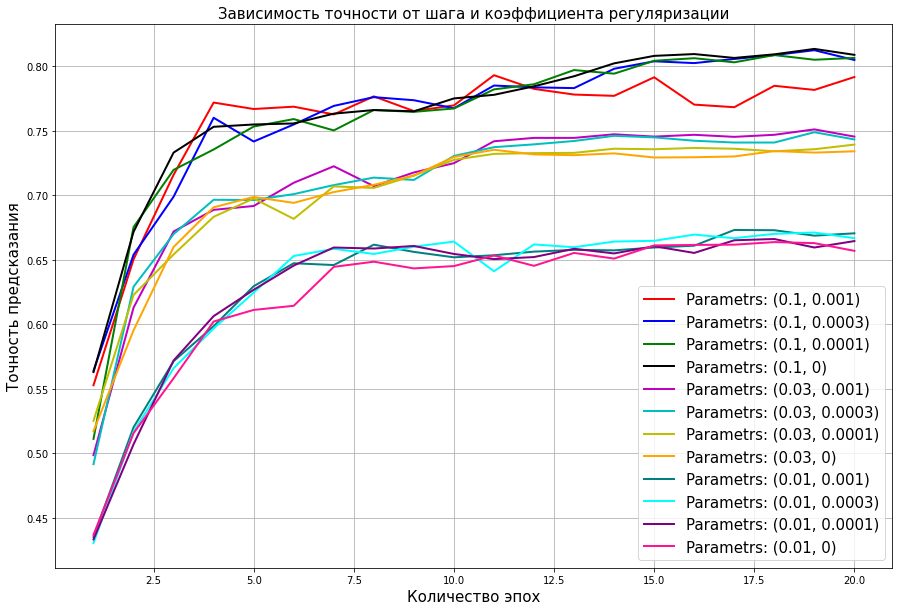

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и коэффициента регуляризации', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
j = 0
for param, accuracy in test_accuracy_history_sgd.items():
    plt.plot(range(1, 21), accuracy, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('sgd_2_accrucy.png')

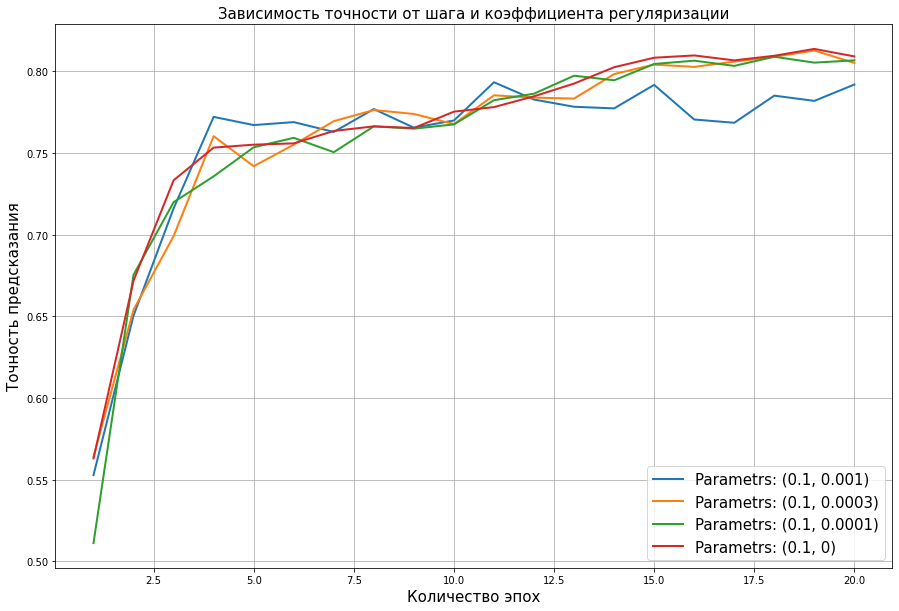

In [ ]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и коэффициента регуляризации', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
for  param in product([0.1], [1e-3, 3e-4, 1e-4, 0]):
    plt.plot(range(1, 21), test_accuracy_history_sgd[param], label = "Parametrs: " + str(param), linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('sgd_2_accrucy_small.png')

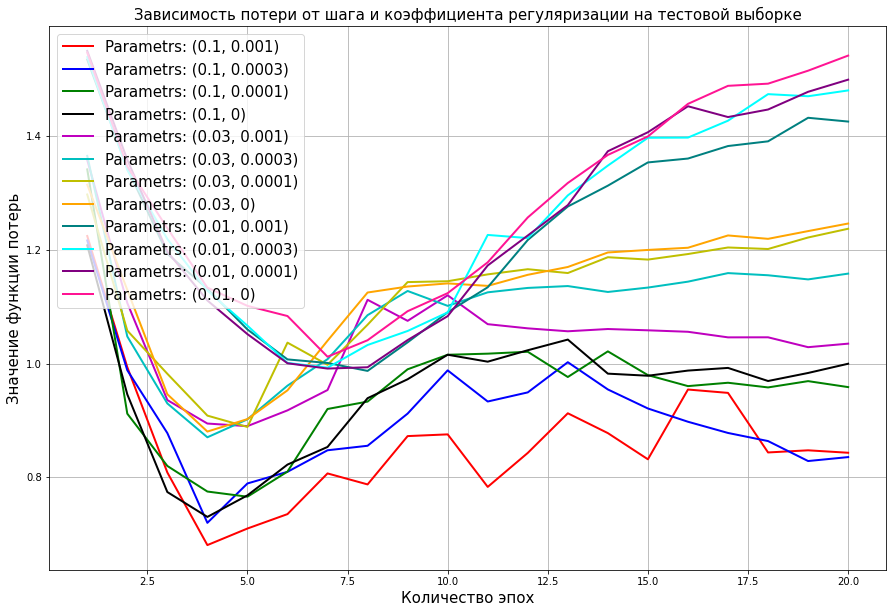

In [ ]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на тестовой выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in test_loss_history_sgd.items():
    plt.plot(range(1, 21), list(map(lambda x: x.item(), loss)), label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15, loc='upper left')
plt.grid(True)
plt.savefig('sgd_2_loss.png')

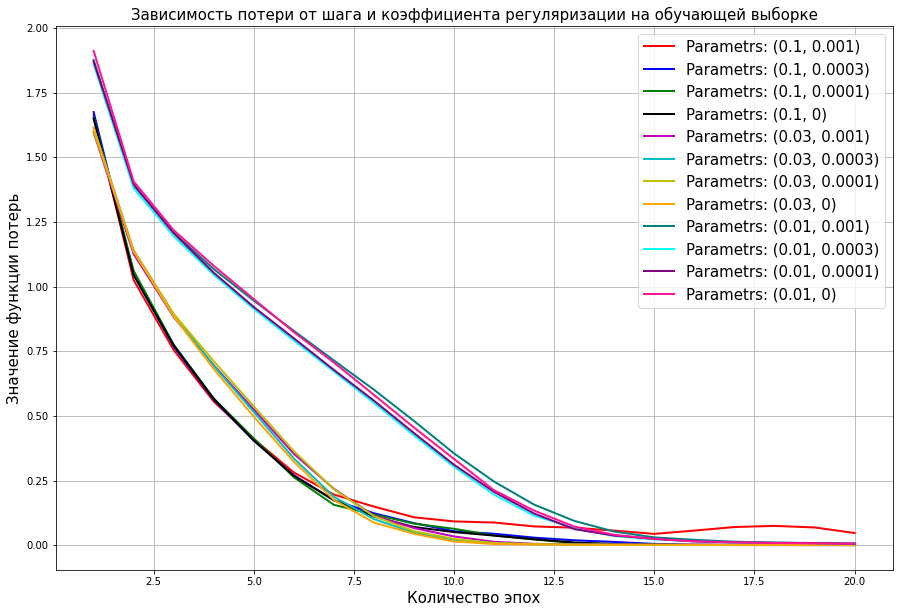

In [ ]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на обучающей выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in loss_in_training_sgd.items():
    plt.plot(range(1, 21), loss, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('sgd_2_loss_train.png')

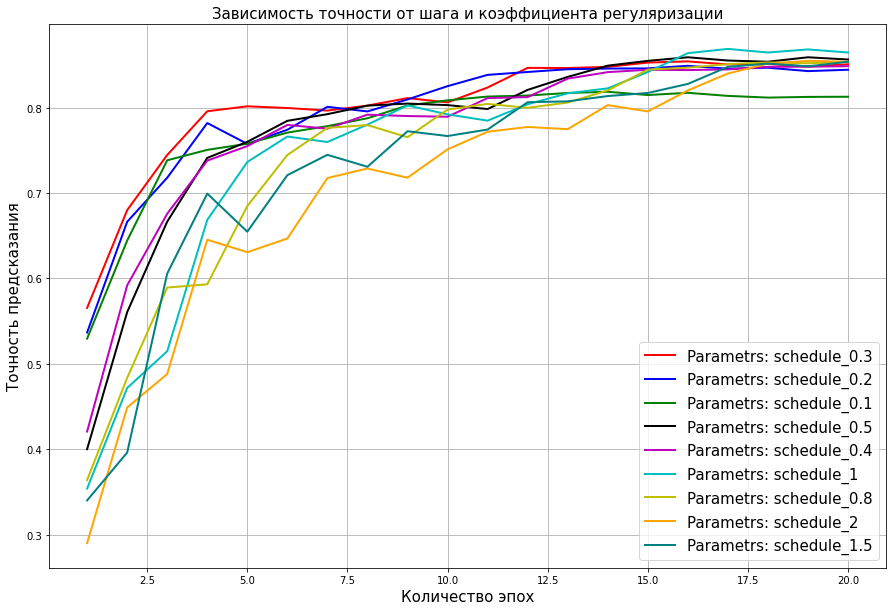

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и коэффициента регуляризации', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
j = 0
for param, accuracy in test_accuracy_history_sgd.items():
    if param[0] == 's':
        plt.plot(range(1, 21), accuracy, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
        j += 1
plt.legend(fontsize = 15)
plt.grid(True)

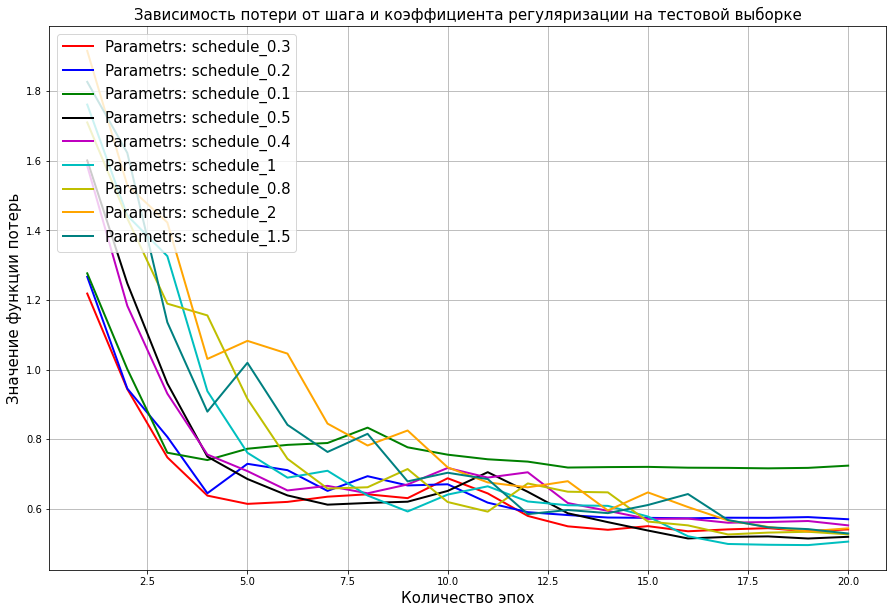

In [9]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на тестовой выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in test_loss_history_sgd.items():
    if param[0] == 's':
        plt.plot(range(1, 21), list(map(lambda x: x.item(), loss)), label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
        j += 1
plt.legend(fontsize = 15, loc='upper left')
plt.grid(True)

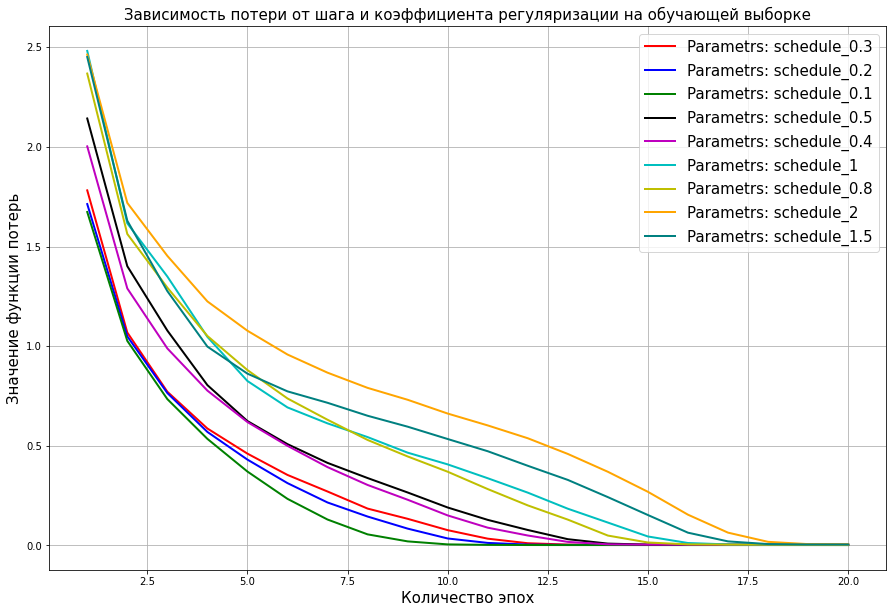

In [10]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на обучающей выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in loss_in_training_sgd.items():
    if param[0] == 's':
        plt.plot(range(1, 21), loss, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
        j += 1
plt.legend(fontsize = 15)
plt.grid(True)

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
trainset, valset = torch.utils.data.random_split(trainset, [46000, 4000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [ ]:
resume = True

if resume: 
    with open('sgd_results.pkl', 'rb') as f:
        arr = pickle.load(f)
        test_accuracy_history_sgd = arr["acc"]
        test_loss_history_sgd = arr["loss"]
        loss_in_training_sgd = arr["loss_train"]
        time_learning_sgd = arr["time"]
else:
    test_accuracy_history_sgd, test_loss_history_sgd, loss_in_training_sgd, time_learning_sgd = {}, {}, {}, {}

In [7]:
import tqdm

In [8]:
lenet = torchvision.models.resnet18(pretrained=False)
lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
lenet.maxpool = torch.nn.Identity()
lenet.cuda()
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(lenet.parameters(), lr=0.1, weight_decay=0.001)

test_loss_history_sgd = list()
test_accuracy_history_sgd = list()
loss_in_training_sgd = list()
time_learning_sgd = list()

for epoch in tqdm.tqdm(range(20)):

    sum_los = 0
    start_time = time.time()

    for i, data in enumerate(trainloader, 0):

        optimizer.zero_grad()

        X_batch, y_batch = data
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        preds = lenet.forward(X_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()
        sum_los += float(loss_value)
        optimizer.step()

    time_learning_sgd.append(time.time() - start_time)
    loss_in_training_sgd.append(sum_los/460)

    correct = 0
    total = 0
    los = 0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = lenet.forward(images)
            outputs = outputs.cuda()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            loss_value = loss(outputs, labels)
            total += labels.size(0)
            los += loss_value


    test_loss_history_sgd.append(los/100)
    print('los epoch', epoch, ':', los/100)

    test_accuracy_history_sgd.append(correct/total)
    print('accuracy epoch', epoch, ':', correct/total)

print(test_accuracy_history_sgd)
print(loss_in_training_sgd)
with open('sgd_bresults.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_sgd, "loss": test_loss_history_sgd, "loss_train":loss_in_training_sgd, "time":time_learning_sgd}, f)

  5%|▌         | 1/20 [00:21<06:56, 21.93s/it]

los epoch 0 : tensor(1.1751, device='cuda:0')
accuracy epoch 0 : 0.5754


 10%|█         | 2/20 [00:40<06:03, 20.22s/it]

los epoch 1 : tensor(0.8985, device='cuda:0')
accuracy epoch 1 : 0.6845


 15%|█▌        | 3/20 [01:00<05:36, 19.79s/it]

los epoch 2 : tensor(0.7311, device='cuda:0')
accuracy epoch 2 : 0.7466


 20%|██        | 4/20 [01:19<05:15, 19.70s/it]

los epoch 3 : tensor(0.7349, device='cuda:0')
accuracy epoch 3 : 0.7553


 25%|██▌       | 5/20 [01:39<04:54, 19.62s/it]

los epoch 4 : tensor(0.6866, device='cuda:0')
accuracy epoch 4 : 0.7742


 30%|███       | 6/20 [01:58<04:34, 19.59s/it]

los epoch 5 : tensor(0.7682, device='cuda:0')
accuracy epoch 5 : 0.7597


 35%|███▌      | 7/20 [02:18<04:14, 19.57s/it]

los epoch 6 : tensor(0.7572, device='cuda:0')
accuracy epoch 6 : 0.7772


 40%|████      | 8/20 [02:37<03:54, 19.57s/it]

los epoch 7 : tensor(0.7573, device='cuda:0')
accuracy epoch 7 : 0.7818


 45%|████▌     | 9/20 [02:57<03:35, 19.59s/it]

los epoch 8 : tensor(0.7694, device='cuda:0')
accuracy epoch 8 : 0.7939


 50%|█████     | 10/20 [03:17<03:15, 19.58s/it]

los epoch 9 : tensor(0.8196, device='cuda:0')
accuracy epoch 9 : 0.7814


 55%|█████▌    | 11/20 [03:36<02:56, 19.60s/it]

los epoch 10 : tensor(0.8357, device='cuda:0')
accuracy epoch 10 : 0.7807


 60%|██████    | 12/20 [03:56<02:36, 19.62s/it]

los epoch 11 : tensor(0.8528, device='cuda:0')
accuracy epoch 11 : 0.7827


 65%|██████▌   | 13/20 [04:15<02:17, 19.60s/it]

los epoch 12 : tensor(0.8177, device='cuda:0')
accuracy epoch 12 : 0.7957


 70%|███████   | 14/20 [04:35<01:57, 19.58s/it]

los epoch 13 : tensor(0.7770, device='cuda:0')
accuracy epoch 13 : 0.8008


 75%|███████▌  | 15/20 [04:55<01:37, 19.59s/it]

los epoch 14 : tensor(0.7716, device='cuda:0')
accuracy epoch 14 : 0.8067


 80%|████████  | 16/20 [05:14<01:18, 19.61s/it]

los epoch 15 : tensor(0.7282, device='cuda:0')
accuracy epoch 15 : 0.815


 85%|████████▌ | 17/20 [05:34<00:58, 19.61s/it]

los epoch 16 : tensor(0.6870, device='cuda:0')
accuracy epoch 16 : 0.8286


 90%|█████████ | 18/20 [05:53<00:39, 19.60s/it]

los epoch 17 : tensor(0.6507, device='cuda:0')
accuracy epoch 17 : 0.8329


 95%|█████████▌| 19/20 [06:13<00:19, 19.59s/it]

los epoch 18 : tensor(0.6359, device='cuda:0')
accuracy epoch 18 : 0.8348


100%|██████████| 20/20 [06:33<00:00, 19.66s/it]

los epoch 19 : tensor(0.6275, device='cuda:0')
accuracy epoch 19 : 0.8354
[0.5754, 0.6845, 0.7466, 0.7553, 0.7742, 0.7597, 0.7772, 0.7818, 0.7939, 0.7814, 0.7807, 0.7827, 0.7957, 0.8008, 0.8067, 0.815, 0.8286, 0.8329, 0.8348, 0.8354]
[1.6723583680132161, 1.040835228173629, 0.7628059238843296, 0.5748695810851844, 0.41966968065370686, 0.3031757553634436, 0.21368710042341896, 0.16092620646662037, 0.12230759048429521, 0.09703611123740025, 0.08804831129053364, 0.07104071327788836, 0.05764419618467598, 0.035204693838022647, 0.017105599779271237, 0.01209816618559315, 0.005265814122116274, 0.002603502570570487, 0.0023245546372060704, 0.0025069451217701578]


In [9]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
trainset, valset = torch.utils.data.random_split(trainset, [46000, 4000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [11]:
lenet = torchvision.models.resnet18(pretrained=False)
lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
lenet.maxpool = torch.nn.Identity()
lenet.cuda()
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(lenet.parameters(), lr=0.1, weight_decay=0.001)

test_loss_history_sgd = list()
test_accuracy_history_sgd = list()
loss_in_training_sgd = list()
time_learning_sgd = list()

test_accuracy = 0

while test_accuracy <= 0.75:

    sum_los = 0
    start_time = time.time()

    for i, data in enumerate(trainloader, 0):

        optimizer.zero_grad()

        X_batch, y_batch = data
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        preds = lenet.forward(X_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()
        sum_los += float(loss_value)
        optimizer.step()

    time_learning_sgd.append(time.time() - start_time)
    loss_in_training_sgd.append(sum_los/460)

    correct = 0
    total = 0
    los = 0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = lenet.forward(images)
            outputs = outputs.cuda()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            loss_value = loss(outputs, labels)
            total += labels.size(0)
            los += loss_value


    test_loss_history_sgd.append(los/100)
    print('los epoch:', los/100)

    test_accuracy = correct/total
    test_accuracy_history_sgd.append(test_accuracy)
    print('accuracy epoch:', test_accuracy)

print(test_accuracy_history_sgd)
print(loss_in_training_sgd)
with open('sgd_bresults_75.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_sgd, "loss": test_loss_history_sgd, "loss_train":loss_in_training_sgd, "time":time_learning_sgd}, f)

los epoch: tensor(1.2673, device='cuda:0')
accuracy epoch: 0.5394
los epoch: tensor(0.8996, device='cuda:0')
accuracy epoch: 0.6821
los epoch: tensor(0.7488, device='cuda:0')
accuracy epoch: 0.74
los epoch: tensor(0.7246, device='cuda:0')
accuracy epoch: 0.7526
[0.5394, 0.6821, 0.74, 0.7526]
[1.6498580989630327, 1.0197545700747035, 0.7474683680612108, 0.5519121029454729]


In [14]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
trainset, valset = torch.utils.data.random_split(trainset, [46000, 4000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [16]:
lenet = torchvision.models.resnet18(pretrained=False)
lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
lenet.maxpool = torch.nn.Identity()
lenet.cuda()
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(lenet.parameters(), lr=1, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

test_loss_history_sgd = list()
test_accuracy_history_sgd = list()
loss_in_training_sgd = list()
time_learning_sgd = list()

for epoch in tqdm.tqdm(range(20)):

    sum_los = 0
    start_time = time.time()

    for i, data in enumerate(trainloader, 0):

        optimizer.zero_grad()

        X_batch, y_batch = data
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        preds = lenet.forward(X_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()
        sum_los += float(loss_value)
        optimizer.step()
    
    scheduler.step()
    time_learning_sgd.append(time.time() - start_time)
    loss_in_training_sgd.append(sum_los/460)

    correct = 0
    total = 0
    los = 0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = lenet.forward(images)
            outputs = outputs.cuda()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            loss_value = loss(outputs, labels)
            total += labels.size(0)
            los += loss_value


    test_loss_history_sgd.append(los/100)
    print('los epoch', epoch, ':', los/100)

    test_accuracy_history_sgd.append(correct/total)
    print('accuracy epoch', epoch, ':', correct/total)

print(test_accuracy_history_sgd)
print(loss_in_training_sgd)
with open('sgd_bresults_scheduler.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_sgd, "loss": test_loss_history_sgd, "loss_train":loss_in_training_sgd, "time":time_learning_sgd}, f)

  5%|▌         | 1/20 [00:18<05:58, 18.86s/it]

los epoch 0 : tensor(1.8789, device='cuda:0')
accuracy epoch 0 : 0.2995


 10%|█         | 2/20 [00:37<05:41, 18.99s/it]

los epoch 1 : tensor(1.4774, device='cuda:0')
accuracy epoch 1 : 0.463


 15%|█▌        | 3/20 [00:57<05:24, 19.11s/it]

los epoch 2 : tensor(1.2160, device='cuda:0')
accuracy epoch 2 : 0.5694


 20%|██        | 4/20 [01:16<05:07, 19.19s/it]

los epoch 3 : tensor(1.0323, device='cuda:0')
accuracy epoch 3 : 0.6348


 25%|██▌       | 5/20 [01:36<04:49, 19.32s/it]

los epoch 4 : tensor(0.8673, device='cuda:0')
accuracy epoch 4 : 0.6944


 30%|███       | 6/20 [01:55<04:32, 19.43s/it]

los epoch 5 : tensor(0.7614, device='cuda:0')
accuracy epoch 5 : 0.7413


 35%|███▌      | 7/20 [02:15<04:12, 19.44s/it]

los epoch 6 : tensor(0.6791, device='cuda:0')
accuracy epoch 6 : 0.7736


 40%|████      | 8/20 [02:34<03:53, 19.50s/it]

los epoch 7 : tensor(0.6707, device='cuda:0')
accuracy epoch 7 : 0.7735


 45%|████▌     | 9/20 [02:54<03:35, 19.56s/it]

los epoch 8 : tensor(0.6814, device='cuda:0')
accuracy epoch 8 : 0.7729


 50%|█████     | 10/20 [03:13<03:15, 19.53s/it]

los epoch 9 : tensor(0.6973, device='cuda:0')
accuracy epoch 9 : 0.7729


 55%|█████▌    | 11/20 [03:33<02:55, 19.54s/it]

los epoch 10 : tensor(0.6300, device='cuda:0')
accuracy epoch 10 : 0.7914


 60%|██████    | 12/20 [03:53<02:36, 19.55s/it]

los epoch 11 : tensor(0.6517, device='cuda:0')
accuracy epoch 11 : 0.7984


 65%|██████▌   | 13/20 [04:12<02:17, 19.57s/it]

los epoch 12 : tensor(0.6846, device='cuda:0')
accuracy epoch 12 : 0.7939


 70%|███████   | 14/20 [04:32<01:57, 19.57s/it]

los epoch 13 : tensor(0.6527, device='cuda:0')
accuracy epoch 13 : 0.8075


 75%|███████▌  | 15/20 [04:51<01:37, 19.54s/it]

los epoch 14 : tensor(0.6131, device='cuda:0')
accuracy epoch 14 : 0.8342


 80%|████████  | 16/20 [05:11<01:17, 19.50s/it]

los epoch 15 : tensor(0.5449, device='cuda:0')
accuracy epoch 15 : 0.8529


 85%|████████▌ | 17/20 [05:30<00:58, 19.48s/it]

los epoch 16 : tensor(0.5254, device='cuda:0')
accuracy epoch 16 : 0.8581


 90%|█████████ | 18/20 [05:50<00:39, 19.53s/it]

los epoch 17 : tensor(0.5183, device='cuda:0')
accuracy epoch 17 : 0.859


 95%|█████████▌| 19/20 [06:09<00:19, 19.54s/it]

los epoch 18 : tensor(0.5160, device='cuda:0')
accuracy epoch 18 : 0.8586


100%|██████████| 20/20 [06:29<00:00, 19.47s/it]

los epoch 19 : tensor(0.5157, device='cuda:0')
accuracy epoch 19 : 0.8592
[0.2995, 0.463, 0.5694, 0.6348, 0.6944, 0.7413, 0.7736, 0.7735, 0.7729, 0.7729, 0.7914, 0.7984, 0.7939, 0.8075, 0.8342, 0.8529, 0.8581, 0.859, 0.8586, 0.8592]
[2.4251029543254687, 1.633284660525944, 1.3590753325949545, 1.0916429274755977, 0.8673972863218059, 0.7340963493870653, 0.6447300310368124, 0.5636567202599152, 0.49511055528469705, 0.41983957190228544, 0.3503681267085283, 0.2685763307725606, 0.1882832379201832, 0.11044403608159527, 0.044616134379706955, 0.011977950304382198, 0.005144830351776403, 0.004292632250682167, 0.004148878121201921, 0.004011448550179763]
